In [1]:
!pip install keras


In [2]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [3]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D,Conv2DTranspose,Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [4]:
def conv_block(x, n_base, batch_normalization):
    
    x = Conv2D(filters=n_base, kernel_size=(3,3), 
                        strides=(1,1),padding='same')(x)
    if (batch_normalization):
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=n_base, kernel_size=(3,3), 
                        strides=(1,1),padding='same')(x)
    if (batch_normalization):
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [5]:
def downsample_block(x, n_base, batch_normalization, dropout):
    f = conv_block(x, n_base, batch_normalization)
    p = layers.MaxPool2D(pool_size = (2,2))(f)
    if(dropout):
        p = layers.Dropout(0.2)(p)
        
    return f, p

In [6]:
def upsample_block(x, f, n_base, batch_normalization, dropout):
    
    x = Conv2DTranspose(filters=n_base, kernel_size=(2,2), 
                         strides=(2,2),padding='same')(x)
    x = Concatenate()([x,f])
    if(dropout):
        x = layers.Dropout(0.2)(x)
    x = conv_block(x, n_base, batch_normalization)
        
    return x

In [7]:
def get_unet(img_w, img_h, img_ch, n_base, LR, batch_normalization, dropout):

    
    
    ## Encoder part
#     model = Sequential()
    inputs = layers.Input((img_w, img_h, img_ch))
    
    f1, p1 = downsample_block(inputs, n_base, batch_normalization, dropout)
    f2, p2 = downsample_block(p1, n_base*2, batch_normalization, dropout)
    f3, p3 = downsample_block(p2, n_base*4, batch_normalization, dropout)
    f4, p4 = downsample_block(p3, n_base*8, batch_normalization, dropout)
    
    
    ## Bottleneck
    bottleneck = conv_block(p4, n_base*16, batch_normalization)
    
    ## Decoder part
    p5 = upsample_block(bottleneck, f4, n_base*8, batch_normalization, dropout)
    p6 = upsample_block(p5, f3, n_base*4, batch_normalization, dropout)
    p7 = upsample_block(p6, f2, n_base*2, batch_normalization, dropout)
    p8 = upsample_block(p7, f1, n_base, batch_normalization, dropout)

    
    ## 1 Convo layer
    p9 = Conv2D(filters=1, kernel_size=(1,1), 
                            padding='same')(p8)
    outputs = Activation('sigmoid')(p9)
    

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    
    return model


In [8]:
## Task1a) Lung segmentation in chest X-ray images:
import os
from random import shuffle
from skimage.io import imread
from skimage.transform import resize


image_path = '/DL_course_data/Lab3/MRI/Image' 
mask_path = '/DL_course_data/Lab3/MRI/Mask'



In [9]:
def load_data(image_path,mask_path):
    
    image_list = os.listdir(image_path)
    mask_list = os.listdir(mask_path)
    
    images = []
    masks = []

    for image in image_list:
        img = imread(os.path.join(image_path, image), as_gray=True)  # "as_grey"
        img = resize(img, (240, 240), anti_aliasing=True).astype('float32')
        images.append(img)

    for image in image_list:
        mask = str.replace(image,'.png','_Tumor.png')
        mask_img = imread(os.path.join(mask_path, mask), as_gray=True)
        mask_img = resize(mask_img, (240, 240), anti_aliasing=True).astype('float32')
        masks.append(mask_img)
        
    ## Load data in traditional way
    # img_train, img_val, mask_train, mask_val = train_test_split(images, masks, shuffle = True,
    #                                                   test_size = 0.2)

    images = np.expand_dims(images, axis = -1)
    images = np.array(images)

    masks = np.expand_dims(masks, axis = -1)
    masks = np.array(masks)
    
    return images, masks
    

In [10]:
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [11]:
n_base =8
LR = 1e-4
batch_normalization = True
dropout = True
epochs = 100
Metric= 'Dice Coefficient'
batch_size = 8

img_w, img_h = 240,240
img_ch = 1

In [12]:
images, masks = load_data(image_path,mask_path)

In [13]:
from numpy import uint8
masks = masks.astype(uint8)

In [14]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
cvscores = []


In [15]:
def generator(x_train, y_train, batch_size):
    n_train_sample = len(x_train)
    while True:
        for ind in (range(0, n_train_sample, batch_size)):
            
            batch_img = x_train[ind:ind+batch_size]
            batch_label = y_train[ind:ind+batch_size]
            
            # Sanity check assures batch size always satisfied
            # by repeating the last 2-3 images at last batch.
            length = len(batch_img)
            if length == batch_size:
                pass
            else:
                for tmp in range(batch_size - length):
                    batch_img = np.append(batch_img, np.expand_dims(batch_img[-1],axis=0), axis = 0)
                    batch_label = np.append(batch_label, np.expand_dims(batch_label[-1], axis=0), axis = 0)
        
            backgound_value = x_train.min()
            data_gen_args = dict(rotation_range=10.,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     cval = backgound_value,
                                     zoom_range=0.2,
                                     horizontal_flip = True)
            
            image_datagen = ImageDataGenerator(**data_gen_args)
            mask_datagen = ImageDataGenerator(**data_gen_args)
            
            image_generator = image_datagen.flow(batch_img, shuffle=False,
                                                 batch_size=batch_size,
                                                 seed=1)
            
            mask_generator = mask_datagen.flow(batch_label, shuffle=False,
                                               batch_size=batch_size,
                                               seed=1)
            
            image = image_generator.next()
            label = mask_generator.next()
            
            yield image, label

In [16]:
def show_hist(History): 
    plt.figure(figsize=(3, 3))
    plt.title("Learning curve")
    plt.plot(History.history["loss"], label="loss")
    plt.plot(History.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(History.history["val_loss"]),
            np.min(History.history["val_loss"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.legend()
    plt.show()

    plt.figure

    plt.figure(figsize=(3, 3))
    plt.title("dice_coef")
    plt.plot(History.history["dice_coef"], label="dice_coef")
    plt.plot(History.history["val_dice_coef"], label="val_dice_coef")
    plt.plot( np.argmax(History.history["val_dice_coef"]),
            np.max(History.history["val_dice_coef"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("dice_coef")
    plt.legend()
    plt.show()

    plt.figure

    plt.figure(figsize=(3, 3))
    plt.title("Precision")
    plt.plot(History.history["precision"], label="Precision")
    plt.plot(History.history["val_precision"], label="val_Precision")
    plt.plot( np.argmax(History.history["val_precision"]),
            np.max(History.history["val_precision"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    plt.figure

    plt.figure(figsize=(3, 3))
    plt.title("recall")
    plt.plot(History.history["recall"], label="recall")
    plt.plot(History.history["val_recall"], label="val_recall")
    plt.plot( np.argmax(History.history["val_recall"]),
            np.max(History.history["val_recall"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("recall")
    plt.legend()
    plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 8)  80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-17-020de33da6a3>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator, steps_per_epoch = len(image_train)//batch_size,


Epoch 1/100
783/783 [==============================] - 159s 199ms/step - loss: 0.9459 - dice_coef: 0.0541 - precision: 0.0533 - recall: 0.9427 - val_loss: 0.9513 - val_dice_coef: 0.0487 - val_precision: 0.2432 - val_recall: 0.6327
Epoch 2/100
783/783 [==============================] - 156s 199ms/step - loss: 0.9305 - dice_coef: 0.0695 - precision: 0.1691 - recall: 0.9377 - val_loss: 0.9370 - val_dice_coef: 0.0630 - val_precision: 0.2637 - val_recall: 0.7460
Epoch 3/100
783/783 [==============================] - 156s 199ms/step - loss: 0.9153 - dice_coef: 0.0847 - precision: 0.2172 - recall: 0.9291 - val_loss: 0.9224 - val_dice_coef: 0.0776 - val_precision: 0.3679 - val_recall: 0.7152
Epoch 4/100
783/783 [==============================] - 156s 199ms/step - loss: 0.8921 - dice_coef: 0.1079 - precision: 0.2675 - recall: 0.9207 - val_loss: 0.8987 - val_dice_coef: 0.1013 - val_precision: 0.5222 - val_recall: 0.7183
Epoch 5/100
783/783 [==============================] - 155s 199ms/step - los

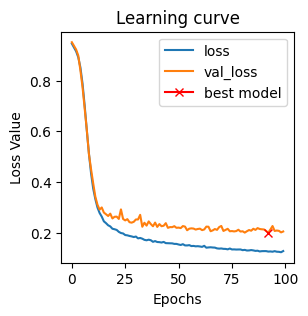

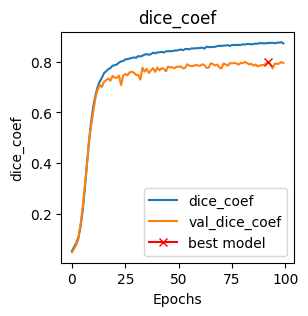

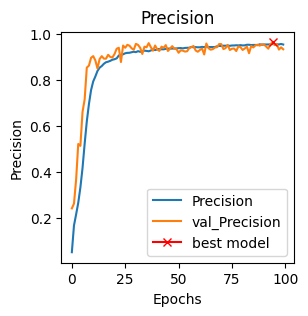

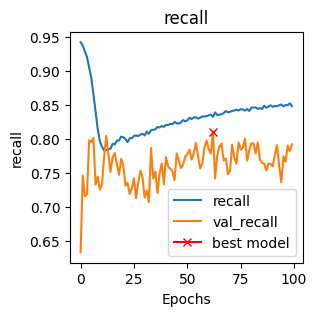

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 8)  80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

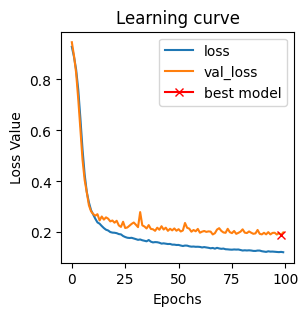

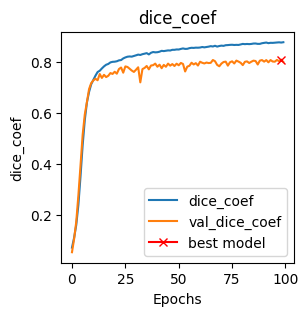

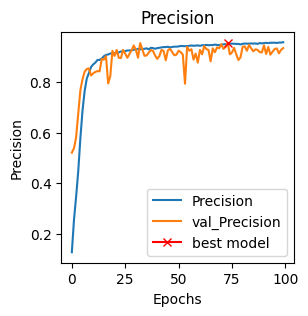

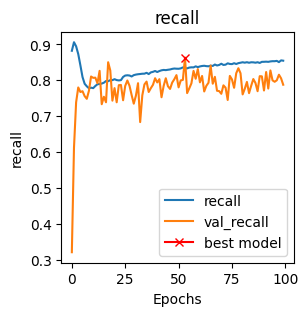

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 8)  80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

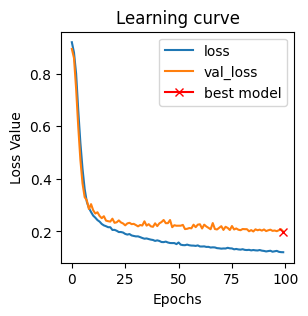

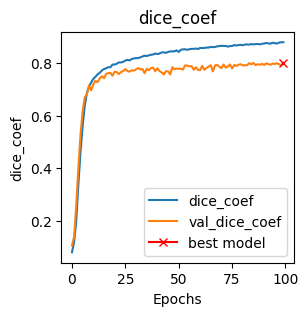

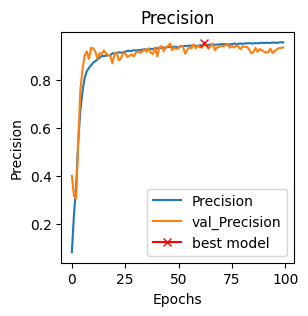

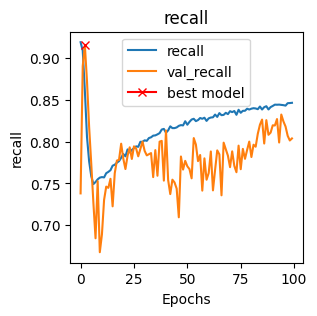

In [17]:
from matplotlib import image
batch_size = 8
for train, val in kf.split(images):
        tf.keras.backend.clear_session()
        image_train, image_val = images[train],images[val]
        mask_train, mask_val = masks[train], masks[val]
        ## Get model
        model = get_unet(img_w, img_h, img_ch, n_base, LR, batch_normalization, dropout)
        train_generator = generator(image_train, mask_train, batch_size)
        val_generator = generator(image_val, mask_val, batch_size)

        # Compile the model
        model.compile(loss = [dice_coef_loss],          # Model Compiling   
                optimizer = Adam(lr = LR),
                metrics = [dice_coef, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

        model_history = model.fit_generator(train_generator, steps_per_epoch = len(image_train)//batch_size,
        validation_data = (val_generator), validation_steps = len(image_val)//batch_size,
        epochs = epochs,  verbose=1)

        # evaluate the model
        show_hist(model_history)



: 